<a href="https://colab.research.google.com/github/x1001000/Colab-Notebooks/blob/main/TFLite_models_invocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download YOLO-Face detection TFLite models

In [ ]:
!gdown --fuzzy 'https://drive.google.com/file/d/1AZuEfDc40XuDZjzNBrsicB83eGp0aCz0/view'
!gdown --fuzzy 'https://drive.google.com/file/d/19cHVov0dxqUcRWWaSJuQMLgm0r2n_3VK/view'

Downloading...
From: https://drive.google.com/uc?id=1AZuEfDc40XuDZjzNBrsicB83eGp0aCz0
To: /content/yolov8m_200e_float32.tflite
100% 12.3M/12.3M [00:00<00:00, 45.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=19cHVov0dxqUcRWWaSJuQMLgm0r2n_3VK
To: /content/yolov8n_100e_float16.tflite
100% 6.18M/6.18M [00:00<00:00, 51.4MB/s]


# Download test.jpg

In [ ]:
!curl https://i0.wp.com/asiatimes.com/wp-content/uploads/2018/09/Taiwan-Asian-Games.jpg --output test.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  108k  100  108k    0     0   258k      0 --:--:-- --:--:-- --:--:--  258k


# Select a model (size: m > n)

In [ ]:
Select = "yolov8m_200e_float32.tflite" # @param ["yolov8m_200e_float32.tflite", "yolov8n_100e_float16.tflite"]

import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=Select)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']

# Input test.jpg to YOLO-Face

In [ ]:
raw = tf.io.read_file('test.jpg')
image = tf.image.decode_jpeg(raw, channels=3)
H, W, _ = image.shape
image = tf.image.resize(image, input_shape[1:3]) / 255
input_data = tf.reshape(image, input_shape)
interpreter.set_tensor(input_details[0]['index'], input_data)

# YOLO-Face outputs (1, 5, 8400) shaped array

In [ ]:
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data.shape

(1, 5, 8400)

# Set confidence score_threshold

In [ ]:
score_threshold = 0.4 # @param {"type":"number","placeholder":"0.4"}

# Parse (1, 5, 8400) into (1, n boxes, (x, y, w, h, confidence)) using [Non Max Suppression](https://medium.com/analytics-vidhya/non-max-suppression-nms-6623e6572536)

In [ ]:
import numpy as np
boxes = np.transpose(np.squeeze(output_data))
import cv2
selected_boxes = boxes[[cv2.dnn.NMSBoxes(boxes[:,:4], boxes[:,4], score_threshold=score_threshold, nms_threshold=0.5)]]
selected_boxes.shape

(1, 15, 5)

# Draw n boxes

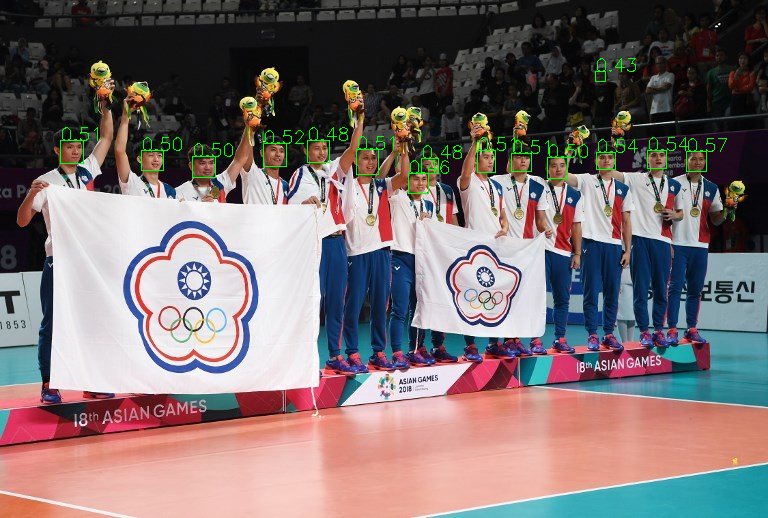

In [ ]:
from google.colab.patches import cv2_imshow
image = cv2.imread('test.jpg')
for box in selected_boxes[0]:
    x, y, w, h = box[:4]
    x, y, w, h = x*W, y*H, w*W, h*H
    cv2.rectangle(image, (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), (0, 255, 0), 1)
    cv2.putText(image, f'{box[4]:.2f}', (int(x-w/2), int(y-h/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)
cv2_imshow(image)